In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def values(func, left, right, n):
    return func(np.linspace(left, right, n))

Функции, которые работают:

In [6]:
def wtt_filter(input_vector, d, modes, ranks, check_correctness=False):
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        assert len(ranks) == d - 1
        prod_modes_manual = 1
        for mode in modes:
            prod_modes_manual *= mode
        assert prod_modes == prod_modes_manual
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
    
    return filters

TODO: $\varepsilon$-стратегия выбора рангов, WTT для больших размерностей (для анализа картинок, например).

In [47]:
def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        prod_modes_manual = 1
        for mode in modes:
            prod_modes_manual *= mode
        assert prod_modes == prod_modes_manual
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [48]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

In [49]:
modes = [2] * d
ranks = [2] * (d - 1)

filters = wtt_filter(
    sqrt_x_values,
    d,
    modes,
    ranks,
    True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

In [50]:
test = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
print(test * np.array([0,0,1]))
print(test * np.array([[0],[0],[1]]))

[[0 0 3]
 [0 0 6]
 [0 0 9]]
[[0 0 0]
 [0 0 0]
 [7 8 9]]


Пайплайн для счёта общей матрицы преобразования $W$:

In [57]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

TODO: возможно, крону с единичной матрицей можно ускорить.

В отличие от статьи, надо поменять порядок в кронах. Стандартная крона:
$$
A \otimes B =
\begin{pmatrix}
a_{11} B & \ldots & a_{1n}B \\
\vdots & \ddots & \vdots \\
a_{m1} B & \ldots & a_{mn}B \\
\end{pmatrix}
$$

Индексы бегают быстрее из $B$, потом --- из $A$. Но раз в той же статье мы хотим $$W_{i_1,...,i_k; j_1,...,j_k} = V^{(1)}_{i_1,j_1} \ldots V^{(k)}_{i_k,k_k} \Rightarrow W = V_1 \otimes \ldots \otimes V_k$$, а запись $W_{i_1,...,i_k; j_1,...,j_k}$ подразумевает, что левые индексы меняются быстро, правые --- медленно (Fortran порядок), то крона должна действовать не как обычно. В общем, при кроне у левой матрицы индексы должны меняться быстро, у правой --- медленно.

In [58]:
W.shape

(1024, 1024)

In [77]:
assert np.allclose(W @ sqrt_x_values, wtt_res)

Как я понимаю, базисные функции --- строки итоговой матрицы (м.б. с нормированием):

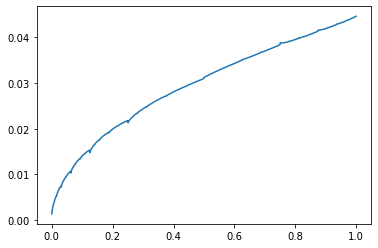

In [78]:
plt.plot(linspace, W[0,:])

Ага, форма такая, но граничные значения разнятся.

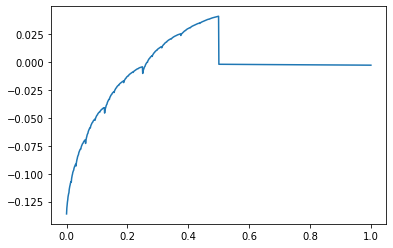

In [82]:
plt.plot(linspace, W[1,:])

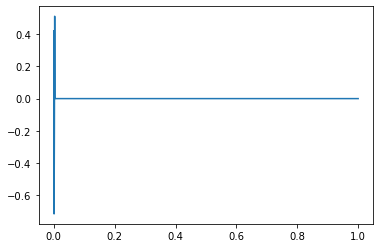

In [89]:
plt.plot(linspace, W[2,:])

In [95]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)

In [96]:
modes = [2] * d
ranks = [2] * (d - 1)

filters = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks,
    True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

In [97]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

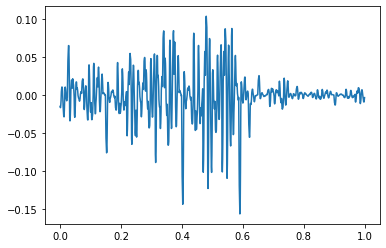

In [98]:
plt.plot(linspace, W[0,:])

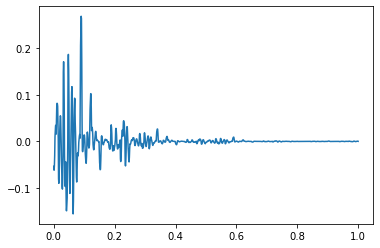

In [99]:
plt.plot(linspace, W[1,:])

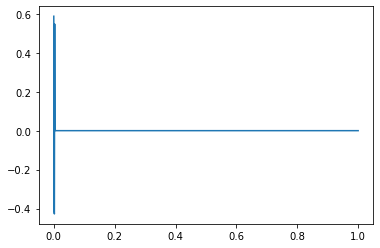

In [100]:
plt.plot(linspace, W[2,:])